In [1]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from torchvision.models import efficientnet_v2_s, resnet50, resnet18
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from torchsummary import summary
import matplotlib.pyplot as plt

In [2]:
data_dir = "../../datasets/data1k"
batch_size = 32
num_classes = 5 
learning_rate = 0.01
num_epochs = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [3]:
# Data Preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
       mean=[0.485, 0.456, 0.406], 
       std=[0.229, 0.224, 0.225]
    )
])

# Load dataset
dataset = ImageFolder(root=data_dir, transform=transform)

# Split dataset into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Class names
class_names = dataset.classes
print("Class Names:", class_names)

# Check data sample
images, labels = next(iter(train_loader))
print(f"Image batch shape: {images.shape}")
print(f"Label batch shape: {labels.shape}")
print(f"train size: {len(train_dataset)}")
print(f"val size: {len(val_dataset)}")

Class Names: ['CBB', 'CBSD', 'CGM', 'CH', 'CMD']
Image batch shape: torch.Size([32, 3, 224, 224])
Label batch shape: torch.Size([32])
train size: 800
val size: 200


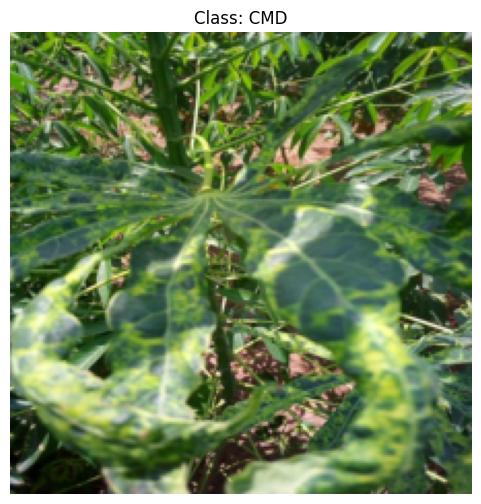

In [4]:
# Function to unnormalize and display the image
def show_image(tensor, title=None):
    # Reverse the normalization: mean and std for ImageNet
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    
    # Clone the tensor to avoid modifying the original
    img = tensor.clone().detach()
    img = img.cpu().numpy().transpose(1, 2, 0)  # Convert from (C, H, W) to (H, W, C)
    img = img * std + mean  # Denormalize
    img = img.clip(0, 1)    # Clip values to [0, 1] range for display
    
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

# Display the first image from the dataset
image, label = dataset[-200]  # Get the first image and its label
show_image(image, title=f"Class: {class_names[label]}")

In [5]:
# Model Definition
model = efficientnet_v2_s(pretrained=True)  
# model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

c:\Users\nicho\anaconda3\envs\EV2\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\nicho\anaconda3\envs\EV2\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_V2_S_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_V2_S_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 24, 112, 112]             648
       BatchNorm2d-2         [-1, 24, 112, 112]              48
              SiLU-3         [-1, 24, 112, 112]               0
            Conv2d-4         [-1, 24, 112, 112]           5,184
       BatchNorm2d-5         [-1, 24, 112, 112]              48
              SiLU-6         [-1, 24, 112, 112]               0
   StochasticDepth-7         [-1, 24, 112, 112]               0
       FusedMBConv-8         [-1, 24, 112, 112]               0
            Conv2d-9         [-1, 24, 112, 112]           5,184
      BatchNorm2d-10         [-1, 24, 112, 112]              48
             SiLU-11         [-1, 24, 112, 112]               0
  StochasticDepth-12         [-1, 24, 112, 112]               0
      FusedMBConv-13         [-1, 24, 112, 112]               0
           Conv2d-14           [-1, 96,

In [7]:
# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [8]:
def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies):
   epochs = range(1, len(train_losses) + 1)
   
   # Plot Loss
   plt.figure(figsize=(10, 5))
   plt.plot(epochs, train_losses, label="Training Loss")
   plt.plot(epochs, val_losses, label="Validation Loss")
   plt.xlabel("Epochs")
   plt.ylabel("Loss")
   plt.title("Training and Validation Loss")
   plt.legend()
   plt.grid(True)
   plt.show()
   
   # Plot Accuracy
   plt.figure(figsize=(10, 5))
   plt.plot(epochs, train_accuracies, label="Training Accuracy")
   plt.plot(epochs, val_accuracies, label="Validation Accuracy")
   plt.xlabel("Epochs")
   plt.ylabel("Accuracy")
   plt.title("Training and Validation Accuracy")
   plt.legend()
   plt.grid(True)
   plt.show()

In [9]:
# Updated Training Loop with Visualization Data
def train_model(
    model, train_loader, val_loader, criterion, optimizer, num_epochs, patience=10
):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        # Progress bar for batches
        progress_bar = tqdm(train_loader, desc="Training")
        for images, labels in progress_bar:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            progress_bar.set_postfix(loss=loss.item(), accuracy=100 * correct / total)

        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.2f}%")

        # Validate the model
        val_loss, val_accuracy = validate_model(model, val_loader, criterion)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        # Early stopping logic
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            best_model_state = model.state_dict()
            print(f"Validation loss improved. Saving model at epoch {epoch+1}.")
        else:
            patience_counter += 1
            print(f"No improvement in validation loss for {patience_counter} epoch(s).")

        if patience_counter >= patience:
            print(f"Early stopping triggered after {patience_counter} epochs without improvement.")
            break
    
    # Restore best model state
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print("Restored the best model state.")
    
    # Plot Training and Validation Metrics
    plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)

# Validation Function with Loss Computation
def validate_model(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc="Validation"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    val_loss = running_loss / len(val_loader)
    val_accuracy = 100 * correct / total
    print(f"Validation Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.2f}%")
    return val_loss, val_accuracy

# callback


Epoch 1/100


Training: 100%|██████████| 25/25 [00:10<00:00,  2.46it/s, accuracy=21.9, loss=1.61]


Epoch [1/100], Loss: 2.2603, Accuracy: 21.88%


Validation: 100%|██████████| 7/7 [00:01<00:00,  4.67it/s]


Validation Loss: 97.7493, Accuracy: 22.00%
Validation loss improved. Saving model at epoch 1.
Epoch 2/100


Training: 100%|██████████| 25/25 [00:09<00:00,  2.58it/s, accuracy=28.1, loss=1.57]


Epoch [2/100], Loss: 1.6096, Accuracy: 28.12%


Validation: 100%|██████████| 7/7 [00:01<00:00,  4.73it/s]


Validation Loss: 1.9208, Accuracy: 25.00%
Validation loss improved. Saving model at epoch 2.
Epoch 3/100


Training: 100%|██████████| 25/25 [00:09<00:00,  2.56it/s, accuracy=30.9, loss=1.5] 


Epoch [3/100], Loss: 1.5245, Accuracy: 30.88%


Validation: 100%|██████████| 7/7 [00:01<00:00,  4.72it/s]


Validation Loss: 1.7100, Accuracy: 21.00%
Validation loss improved. Saving model at epoch 3.
Epoch 4/100


Training: 100%|██████████| 25/25 [00:09<00:00,  2.57it/s, accuracy=29.6, loss=1.46]


Epoch [4/100], Loss: 1.5096, Accuracy: 29.62%


Validation: 100%|██████████| 7/7 [00:01<00:00,  4.69it/s]


Validation Loss: 1.5958, Accuracy: 27.00%
Validation loss improved. Saving model at epoch 4.
Epoch 5/100


Training: 100%|██████████| 25/25 [00:09<00:00,  2.57it/s, accuracy=31.1, loss=1.27]


Epoch [5/100], Loss: 1.5141, Accuracy: 31.12%


Validation: 100%|██████████| 7/7 [00:01<00:00,  4.79it/s]


Validation Loss: 1.7797, Accuracy: 24.00%
No improvement in validation loss for 1 epoch(s).
Epoch 6/100


Training: 100%|██████████| 25/25 [00:09<00:00,  2.56it/s, accuracy=33.4, loss=1.55]


Epoch [6/100], Loss: 1.4370, Accuracy: 33.38%


Validation: 100%|██████████| 7/7 [00:01<00:00,  4.75it/s]


Validation Loss: 1.4989, Accuracy: 29.00%
Validation loss improved. Saving model at epoch 6.
Epoch 7/100


Training: 100%|██████████| 25/25 [00:09<00:00,  2.60it/s, accuracy=33.6, loss=1.27]


Epoch [7/100], Loss: 1.4522, Accuracy: 33.62%


Validation: 100%|██████████| 7/7 [00:01<00:00,  4.62it/s]


Validation Loss: 1.4730, Accuracy: 30.50%
Validation loss improved. Saving model at epoch 7.
Epoch 8/100


Training: 100%|██████████| 25/25 [00:09<00:00,  2.56it/s, accuracy=36.9, loss=1.52]


Epoch [8/100], Loss: 1.4006, Accuracy: 36.88%


Validation: 100%|██████████| 7/7 [00:01<00:00,  4.69it/s]


Validation Loss: 2.0015, Accuracy: 21.50%
No improvement in validation loss for 1 epoch(s).
Epoch 9/100


Training: 100%|██████████| 25/25 [00:09<00:00,  2.57it/s, accuracy=36, loss=1.51]  


Epoch [9/100], Loss: 1.4699, Accuracy: 36.00%


Validation: 100%|██████████| 7/7 [00:01<00:00,  4.47it/s]


Validation Loss: 1.8453, Accuracy: 27.00%
No improvement in validation loss for 2 epoch(s).
Epoch 10/100


Training: 100%|██████████| 25/25 [00:09<00:00,  2.54it/s, accuracy=37.1, loss=1.5] 


Epoch [10/100], Loss: 1.4413, Accuracy: 37.12%


Validation: 100%|██████████| 7/7 [00:01<00:00,  4.73it/s]


Validation Loss: 1.5930, Accuracy: 25.50%
No improvement in validation loss for 3 epoch(s).
Epoch 11/100


Training: 100%|██████████| 25/25 [00:09<00:00,  2.50it/s, accuracy=36.6, loss=1.6] 


Epoch [11/100], Loss: 1.4554, Accuracy: 36.62%


Validation: 100%|██████████| 7/7 [00:01<00:00,  4.71it/s]


Validation Loss: 1.5518, Accuracy: 32.00%
No improvement in validation loss for 4 epoch(s).
Epoch 12/100


Training: 100%|██████████| 25/25 [00:09<00:00,  2.54it/s, accuracy=37.8, loss=1.22]


Epoch [12/100], Loss: 1.3910, Accuracy: 37.75%


Validation: 100%|██████████| 7/7 [00:01<00:00,  4.67it/s]


Validation Loss: 1.5311, Accuracy: 35.50%
No improvement in validation loss for 5 epoch(s).
Epoch 13/100


Training: 100%|██████████| 25/25 [00:09<00:00,  2.54it/s, accuracy=39.5, loss=1.46] 


Epoch [13/100], Loss: 1.3530, Accuracy: 39.50%


Validation: 100%|██████████| 7/7 [00:01<00:00,  4.78it/s]


Validation Loss: 1.4585, Accuracy: 36.00%
Validation loss improved. Saving model at epoch 13.
Epoch 14/100


Training: 100%|██████████| 25/25 [00:09<00:00,  2.56it/s, accuracy=40.4, loss=1.33]


Epoch [14/100], Loss: 1.3253, Accuracy: 40.38%


Validation: 100%|██████████| 7/7 [00:01<00:00,  4.67it/s]


Validation Loss: 2.1134, Accuracy: 17.00%
No improvement in validation loss for 1 epoch(s).
Epoch 15/100


Training: 100%|██████████| 25/25 [00:09<00:00,  2.56it/s, accuracy=43, loss=1.14]  


Epoch [15/100], Loss: 1.3164, Accuracy: 43.00%


Validation: 100%|██████████| 7/7 [00:01<00:00,  4.45it/s]


Validation Loss: 1.5056, Accuracy: 38.00%
No improvement in validation loss for 2 epoch(s).
Epoch 16/100


Training: 100%|██████████| 25/25 [00:10<00:00,  2.42it/s, accuracy=42.1, loss=1.2] 


Epoch [16/100], Loss: 1.3622, Accuracy: 42.12%


Validation: 100%|██████████| 7/7 [00:01<00:00,  4.47it/s]


Validation Loss: 1.5093, Accuracy: 37.50%
No improvement in validation loss for 3 epoch(s).
Epoch 17/100


Training: 100%|██████████| 25/25 [00:09<00:00,  2.52it/s, accuracy=46.8, loss=1.32]


Epoch [17/100], Loss: 1.2545, Accuracy: 46.75%


Validation: 100%|██████████| 7/7 [00:01<00:00,  4.54it/s]


Validation Loss: 1.5595, Accuracy: 31.00%
No improvement in validation loss for 4 epoch(s).
Epoch 18/100


Training: 100%|██████████| 25/25 [00:10<00:00,  2.44it/s, accuracy=47.5, loss=1.15] 


Epoch [18/100], Loss: 1.2258, Accuracy: 47.50%


Validation: 100%|██████████| 7/7 [00:01<00:00,  4.31it/s]


Validation Loss: 1.5698, Accuracy: 35.00%
No improvement in validation loss for 5 epoch(s).
Epoch 19/100


Training: 100%|██████████| 25/25 [00:10<00:00,  2.43it/s, accuracy=50.6, loss=1.11] 


Epoch [19/100], Loss: 1.1772, Accuracy: 50.62%


Validation: 100%|██████████| 7/7 [00:01<00:00,  4.53it/s]


Validation Loss: 1.8295, Accuracy: 33.50%
No improvement in validation loss for 6 epoch(s).
Epoch 20/100


Training: 100%|██████████| 25/25 [00:11<00:00,  2.25it/s, accuracy=52.4, loss=1.08] 


Epoch [20/100], Loss: 1.1228, Accuracy: 52.38%


Validation: 100%|██████████| 7/7 [00:02<00:00,  3.43it/s]


Validation Loss: 1.7702, Accuracy: 31.50%
No improvement in validation loss for 7 epoch(s).
Epoch 21/100


Training: 100%|██████████| 25/25 [00:11<00:00,  2.09it/s, accuracy=49.1, loss=1.04]


Epoch [21/100], Loss: 1.1723, Accuracy: 49.12%


Validation: 100%|██████████| 7/7 [00:01<00:00,  3.51it/s]


Validation Loss: 1.8066, Accuracy: 30.50%
No improvement in validation loss for 8 epoch(s).
Epoch 22/100


Training: 100%|██████████| 25/25 [00:11<00:00,  2.13it/s, accuracy=51.1, loss=1.35] 


Epoch [22/100], Loss: 1.1105, Accuracy: 51.12%


Validation: 100%|██████████| 7/7 [00:01<00:00,  3.61it/s]


Validation Loss: 1.8788, Accuracy: 32.00%
No improvement in validation loss for 9 epoch(s).
Epoch 23/100


Training: 100%|██████████| 25/25 [00:09<00:00,  2.52it/s, accuracy=55.6, loss=1.01] 


Epoch [23/100], Loss: 1.0482, Accuracy: 55.62%


Validation: 100%|██████████| 7/7 [00:01<00:00,  4.67it/s]

Validation Loss: 1.5830, Accuracy: 34.00%
No improvement in validation loss for 10 epoch(s).
Early stopping triggered after 10 epochs without improvement.
Restored the best model state.


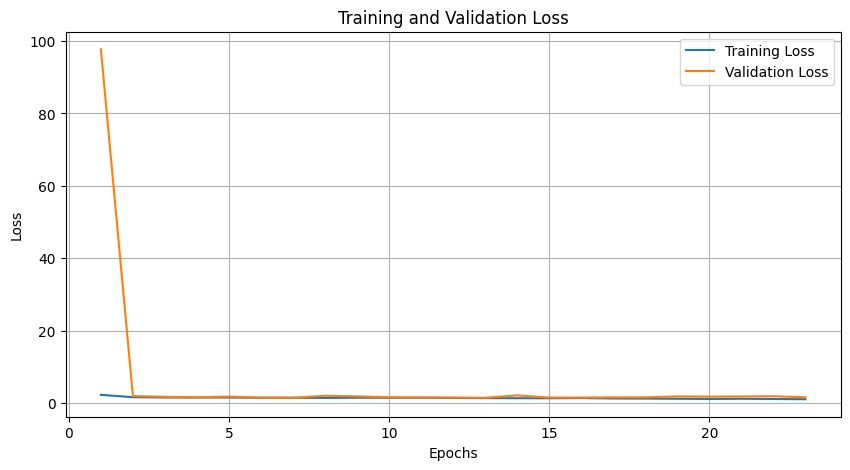

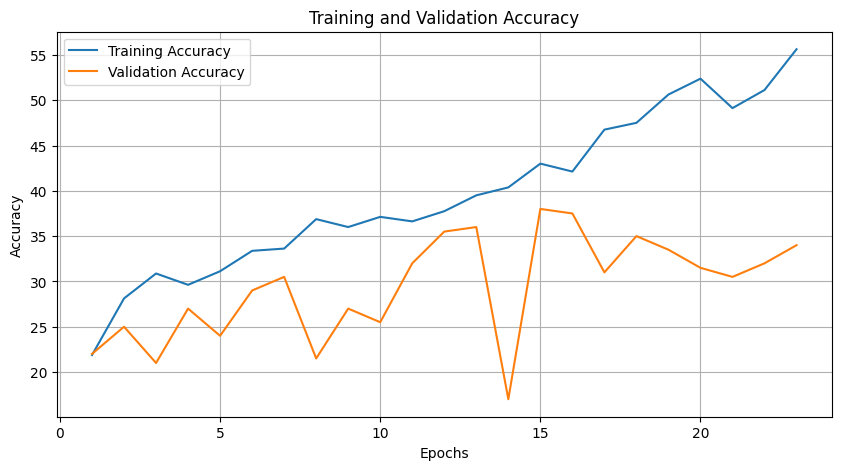

In [10]:
# Start Training
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs)

In [11]:
torch.save(model.state_dict(), "saved_model/efficientnetv2_weights.pth")

In [12]:
torch.save(model, "saved_model/efficientnetv2.pth")

In [13]:
model = torch.load("saved_model/efficientnetv2.pth")
# model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

C:\Users\nicho\AppData\Local\Temp\ipykernel_4600\838212922.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("saved_model/efficientnetv2.pth")


In [14]:
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 24, 112, 112]             648
       BatchNorm2d-2         [-1, 24, 112, 112]              48
              SiLU-3         [-1, 24, 112, 112]               0
            Conv2d-4         [-1, 24, 112, 112]           5,184
       BatchNorm2d-5         [-1, 24, 112, 112]              48
              SiLU-6         [-1, 24, 112, 112]               0
   StochasticDepth-7         [-1, 24, 112, 112]               0
       FusedMBConv-8         [-1, 24, 112, 112]               0
            Conv2d-9         [-1, 24, 112, 112]           5,184
      BatchNorm2d-10         [-1, 24, 112, 112]              48
             SiLU-11         [-1, 24, 112, 112]               0
  StochasticDepth-12         [-1, 24, 112, 112]               0
      FusedMBConv-13         [-1, 24, 112, 112]               0
           Conv2d-14           [-1, 96,

In [15]:
validate_model(model, val_loader, criterion)

Validation: 100%|██████████| 7/7 [00:01<00:00,  4.45it/s]

Validation Loss: 1.5830, Accuracy: 34.00%


(1.58297199010849, 34.0)

Validation: 100%|██████████| 7/7 [00:01<00:00,  4.59it/s]

Classification Report:
              precision    recall  f1-score   support

         CBB       0.48      0.43      0.46        37
        CBSD       0.22      0.08      0.12        49
         CGM       0.26      0.29      0.27        38
          CH       0.29      0.44      0.35        43
         CMD       0.45      0.55      0.49        33

    accuracy                           0.34       200
   macro avg       0.34      0.36      0.34       200
weighted avg       0.33      0.34      0.32       200



<Figure size 1000x700 with 0 Axes>

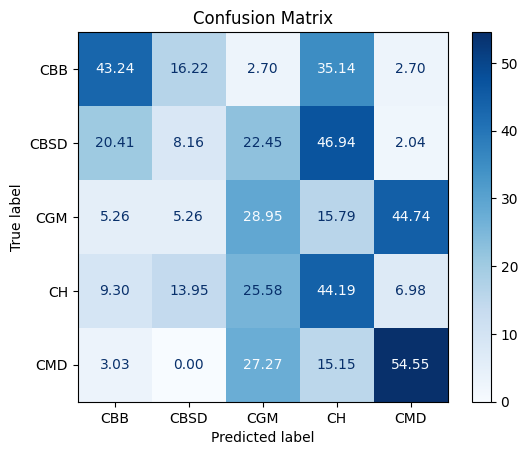

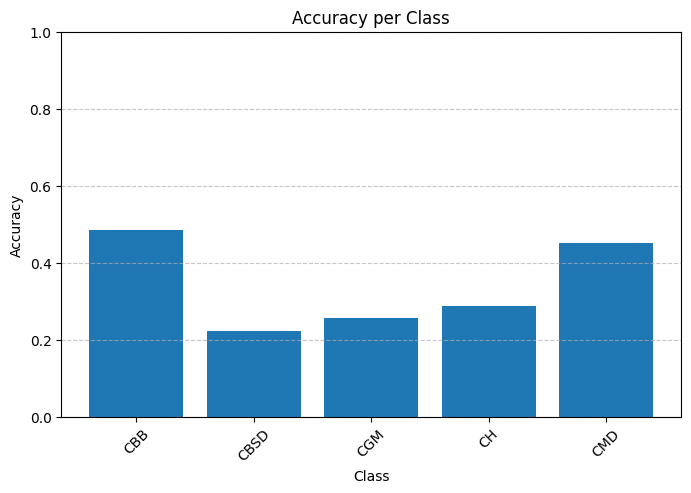

In [16]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm  

def validate_model_with_visuals(model, val_loader, class_names):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc="Validation"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Compute metrics
    cm = confusion_matrix(all_labels, all_preds, labels=range(len(class_names)))
    cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100  # Normalize to percentages
    
    report = classification_report(all_labels, all_preds, target_names=class_names, output_dict=True)
    
    # Display Classification Report
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))
    
    # Plot Confusion Matrix (percentage)
    plt.figure(figsize=(10, 7))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_percentage, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues, values_format=".2f")  # Display as percentages with two decimals
    plt.title("Confusion Matrix")
    plt.show()
    
    # Plot Accuracy per Class
    accuracies = [report[class_name]['precision'] for class_name in class_names]
    plt.figure(figsize=(8, 5))
    plt.bar(class_names, accuracies)
    plt.ylim(0, 1)
    plt.title("Accuracy per Class")
    plt.ylabel("Accuracy")
    plt.xlabel("Class")
    plt.xticks(rotation=45)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()

class_names = dataset.classes
validate_model_with_visuals(model, val_loader, class_names)
